# Vegetation forecasting with machine learning

https://nixtla.github.io/mlforecast/forecast.html



## Description



### Load packages
Import Python packages that are used for the analysis.

In [1]:
# !pip install mlforecast[distributed]

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from datacube import Datacube
import xarray as xr
import pandas as pd
import numpy as np
from dea_tools.datahandling import load_ard
from dea_tools.plotting import display_map
from dea_tools.bandindices import calculate_indices
from dea_tools.dask import create_local_dask_cluster
from load_era5 import load_era5

from sklearn.ensemble import RandomForestRegressor
from mlforecast.distributed.models.xgb import XGBForecast
import mlforecast as mlf
from mlforecast.core import TimeSeries
from mlforecast.forecast import Forecast
import dask.dataframe as dd
from mlforecast.distributed.forecast import DistributedForecast
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean

/env/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## Set up a local dask cluster

In [3]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:32925 Dashboard: /user/chad/proxy/8787/status,Cluster Workers: 1 Cores: 7 Memory: 63.57 GB


### Analysis parameters

Define location and time period of interest.
The time period is chosen to be less than a year to limit ERA5 data download.

In [4]:
# Define the analysis region (Lat-Lon box)
lat, lon =  -33.1763, 121.5559
buffer = 0.006

lon=(lon - buffer, lon + buffer)
lat=(lat - buffer, lat + buffer)

# Define the time window
time = '2013-01-01', '2020-12-30'

#resample frequency
freq='1M'

## Display AOI on interactive map

In [5]:
display_map(lon,lat)

## Extract satellite data

In [6]:
dc = Datacube(app='forecasting')

query = {'lon': lon,
         'lat': lat,
         'time': time,
         'measurements':['nbart_red', 'nbart_nir'],
         'output_crs' :'EPSG:3577',
         'resolution' : (-30, 30),
         'resampling' :{"fmask": "nearest", "*": "bilinear"}}

ds = load_ard(dc=dc, 
              dask_chunks={'x':-1, 'y':-1, 'time':-1},
              products=["ga_ls7e_ard_3", "ga_ls8c_ard_3"],#['s2a_ard_granule','s2b_ard_granule'],
              **query)


/env/lib/python3.6/site-packages/datacube/drivers/postgres/_connections.py:87: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


Finding datasets
    ga_ls7e_ard_3
    ga_ls8c_ard_3
Applying pixel quality/cloud mask
Returning 652 time steps as a dask array


### Calculate NDVI time-series

In [7]:
#calculate NDVI
ndvi = calculate_indices(ds, 'NDVI', drop=True, collection='ga_ls_3')

#interpolate NDVI to a monthly frequency
ndvi = ndvi.interpolate_na(dim='time', method='linear',).resample(time=freq).interpolate("linear")
ndvi=ndvi.mean(['x','y'])
ndvi = ndvi.NDVI.compute()

Dropping bands ['nbart_red', 'nbart_nir']


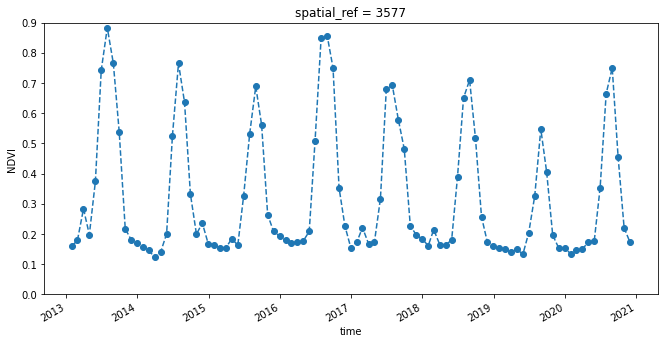

In [8]:
ndvi.plot(figsize=(11,5),linestyle='dashed', marker='o')
plt.ylim(0,0.9);

## Convert to pandas dataframes

And put into a format that will fit the requirements of ml-forecast

In [9]:
#convert to dfs
ndvi=ndvi.drop('spatial_ref').to_dataframe().rename({'NDVI':'y', 'time':'ds'}, axis=1)

#some preprocesing to match ml-forecast requirements
ndvi = ndvi.dropna()
ndvi['unique_id'] = 0
ndvi=ndvi.reset_index().set_index('unique_id', drop=True).rename({'time':'ds'},axis=1)
ndvi.head()

,ds,y
unique_id,,
0,2013-01-31,0.160456
0,2013-02-28,0.179357
0,2013-03-31,0.283401
0,2013-04-30,0.198090
0,2013-05-31,0.374191


## Forecasting with a Random Forest regressor

### Set up a model and time-series object

In [10]:
model = RandomForestRegressor()

In [11]:
ts = TimeSeries(
    freq='M',
    lags=[1,2,3,4],
    lag_transforms={
        1: [expanding_mean],
        1: [(rolling_mean, 3)]
    },
    date_features=['month', 'year'],
    num_threads=6,    
)
ts

TimeSeries(freq=<MonthEnd>, transforms=['lag-1', 'lag-2', 'lag-3', 'lag-4', 'rolling_mean_lag-1_window_size-3'], date_features=['month', 'year'], num_threads=6)

### Perform a back test

In [12]:
n_windows = 3
window_size = 12
fcst = mlf.forecast.Forecast(model, ts)
backtest_results = fcst.backtest(ndvi, n_windows, window_size)

In [13]:
w = []
for i in range(1,n_windows):
    window_result = next(backtest_results)
    w.append(window_result)
    
results = pd.concat(w)

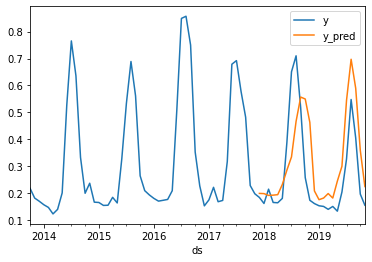

In [14]:
agg_results = results.groupby('ds').sum()
history = ndvi[ndvi.ds < agg_results.index.min()]
agg_history = history.groupby('ds')[['y']].sum().tail(50)
agg_history.append(agg_results).plot();

### Perform a forecast

In [15]:
fcst = mlf.forecast.Forecast(model, ts)
fcst.fit(ndvi)
fcst.ts.features_order_

Index(['lag-1', 'lag-2', 'lag-3', 'lag-4', 'rolling_mean_lag-1_window_size-3',
       'month', 'year'],
      dtype='object')

In [16]:
pred=fcst.predict(12)
pred.head()

,ds,y_pred
unique_id,,
0,2020-12-31,0.175737
0,2021-01-31,0.173672
0,2021-02-28,0.179527
0,2021-03-31,0.212925
0,2021-04-30,0.242929


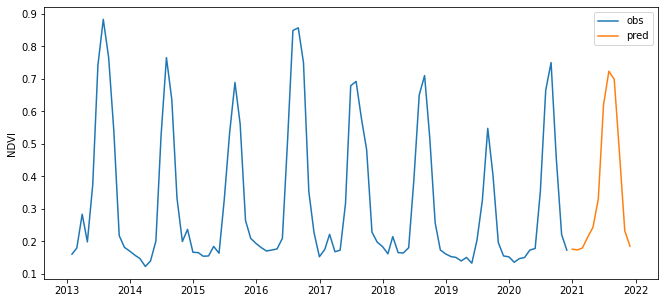

In [17]:
plt.figure(figsize=(11,5))
plt.plot(ndvi['ds'], ndvi['y'], label='obs')
plt.plot(pred['ds'],pred['y_pred'], label='pred')
plt.ylabel('NDVI')
plt.legend();

---

## Advanced: Perform a distributed forecast using dask and XGBoost

First, convert pd.dataframe to a dask.dataframe and set up model and timeseries

In [18]:
for col in ndvi.select_dtypes(include='category'):
    ndvi[col] = ndvi[col].cat.codes  # encode categories for xgboost

lazy_ndvi = dd.from_pandas(ndvi[['ds','y']], npartitions=1)

In [19]:
model = XGBForecast()

In [20]:
ts = TimeSeries(
    freq='M',
    lags=[1,2,3,4],
    lag_transforms={
        1: [expanding_mean],
        1: [(rolling_mean, 3)]
    },
    date_features=['month', 'year'],
    num_threads=6,    
)
ts

TimeSeries(freq=<MonthEnd>, transforms=['lag-1', 'lag-2', 'lag-3', 'lag-4', 'rolling_mean_lag-1_window_size-3'], date_features=['month', 'year'], num_threads=6)

### Back test

In [21]:
n_windows = 3
window_size = 12
fcst = DistributedForecast(model, ts)
backtest_results = fcst.backtest(lazy_ndvi, n_windows, window_size)

In [22]:
w = []
for i in range(1,n_windows):
    window_result = next(backtest_results)
    w.append(window_result.compute())
    
results = pd.concat(w)

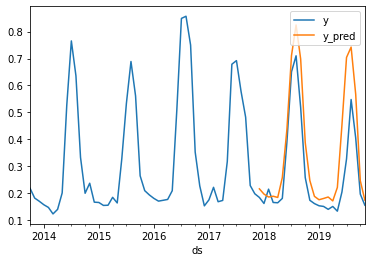

In [23]:
agg_results = results.groupby('ds').sum()
history = ndvi[ndvi.ds < agg_results.index.min()]
agg_history = history.groupby('ds')[['y']].sum().tail(50)
agg_history.append(agg_results).plot();

### Forecast

In [24]:
fcst = DistributedForecast(model, ts)

In [25]:
fcst.fit(lazy_ndvi)

DistributedForecast(model=XGBForecast(base_score=0.5, booster='gbtree', colsample_bylevel=1,
            colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
            interaction_constraints='', learning_rate=0.300000012,
            max_delta_step=0, max_depth=6, min_child_weight=1,
            monotone_constraints='()', n_jobs=7, num_parallel_tree=1,
            objective='reg:squarederror', random_state=0, reg_alpha=0,
            reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='approx',
            validate_parameters=1), dts=DistributedTimeSeries(freq=<MonthEnd>, transforms=['lag-1', 'lag-2', 'lag-3', 'lag-4', 'rolling_mean_lag-1_window_size-3'], date_features=['month', 'year'], num_threads=6))

In [26]:
preds = fcst.predict(12).compute()
preds.head()

,ds,y_pred
unique_id,,
0,2020-12-31,0.153169
0,2021-01-31,0.159201
0,2021-02-28,0.156766
0,2021-03-31,0.141959
0,2021-04-30,0.140032


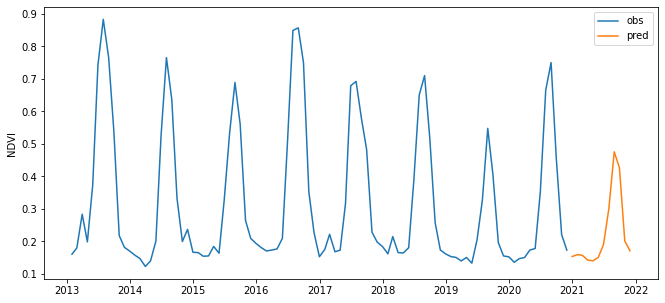

In [27]:
plt.figure(figsize=(11,5))
plt.plot(ndvi['ds'], ndvi['y'], label='obs')
plt.plot(preds['ds'],preds['y_pred'], label='pred')
plt.ylabel('NDVI')
plt.legend();